In [1]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge

from sklearn.metrics import precision_score, recall_score, auc, accuracy_score,\
roc_auc_score, f1_score, log_loss, classification_report,\
roc_curve, confusion_matrix, mean_squared_error

In [13]:
sns.set(rc={'figure.figsize':(8.5, 6.0)})

# Load Data

In [14]:
dataset = pd.read_csv("data/claim_.csv")
dataset.head()

,Unnamed: 0,ID,CHILD_DRIV,AGE,CHILDREN,YOJ,INCOME,HOUSE_VAL,STATUS,GENDER,...,VEHICLE_VAL,VEHICLE_TYPE,CLM_FREQ,REVOKED,MVR_PTS,CLAIM_AMOUNT,VEHICLE_AGE,CLAIM_IND,AREA,STATE_CODE
0,0,6.921625e+09,0,67.0,0,14.0,53.841,359229.0,z_No,Mal,...,21.97,Family,0,No,2,294.000,12.0,0,Highly Urban/ Urban,Berlin
1,1,1.227899e+09,0,26.0,1,13.0,16.999,265527.0,NaN,Fem,...,4.01,unknown,4,No,7,292.000,12.0,0,Highly Urban/ Urban,Thueringen
2,2,1.950524e+09,0,71.0,0,17.0,NaN,323918.0,Yes,Mal,...,15.44,Minivan,0,No,0,387.000,8.0,0,Highly Urban/ Urban,Bayern
3,3,1.743448e+09,0,68.0,0,NaN,115.546,361705.0,Yes,Fem,...,18.00,unknown,4,Yes,3,308.000,19.0,0,Highly Urban/ Urban,Bayern
4,4,7.371333e+09,0,32.0,1,15.0,125.861,70668.0,z_No,Fem,...,17.43,Sports Car,0,No,0,3.221,9.0,1,Highly Urban/ Urban,Bayern


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10300 entries, 0 to 10299
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    10300 non-null  int64  
 1   ID            10300 non-null  float64
 2   CHILD_DRIV    10300 non-null  int64  
 3   AGE           10293 non-null  float64
 4   CHILDREN      10300 non-null  int64  
 5   YOJ           9752 non-null   float64
 6   INCOME        9730 non-null   float64
 7   HOUSE_VAL     9725 non-null   float64
 8   STATUS        10298 non-null  object 
 9   GENDER        10300 non-null  object 
 10  EDU_LEVEL     10300 non-null  object 
 11  JOB           9635 non-null   object 
 12  DISTANCE      10300 non-null  int64  
 13  CAR_USE       10300 non-null  object 
 14  VEHICLE_VAL   10300 non-null  float64
 15  VEHICLE_TYPE  10300 non-null  object 
 16  CLM_FREQ      10300 non-null  int64  
 17  REVOKED       10300 non-null  object 
 18  MVR_PTS       10300 non-nu

# Data Analysis

## Claim Amount

In [16]:
dataset.CLAIM_IND.value_counts()

0    7554
1    2746
Name: CLAIM_IND, dtype: int64

Гипотеза 1: Возраст людей, которые обращаются за строховой выплатой, меньше.

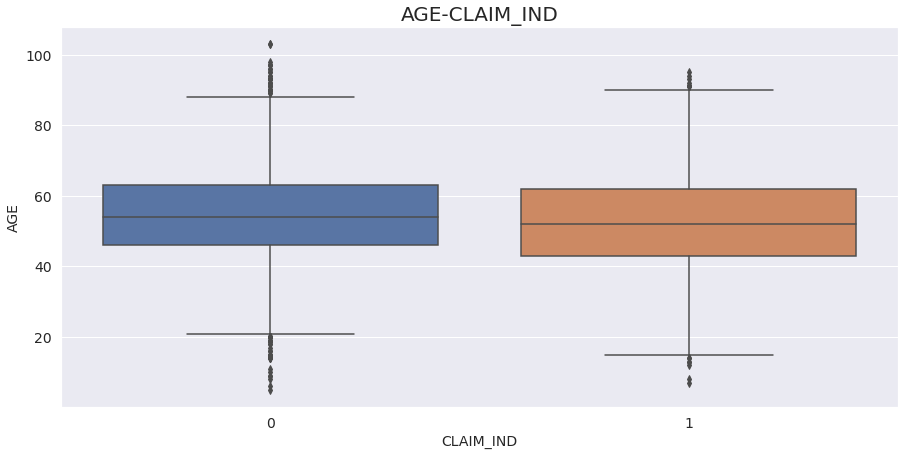

In [27]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='CLAIM_IND', y='AGE', data=dataset)

plt.title('AGE-CLAIM_IND', fontsize=20)
plt.ylabel('AGE', fontsize=14)
plt.xlabel('CLAIM_IND', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Гипотеза 2: Зарплата у людей, которые обращаются за страховой выплатой, меньше.

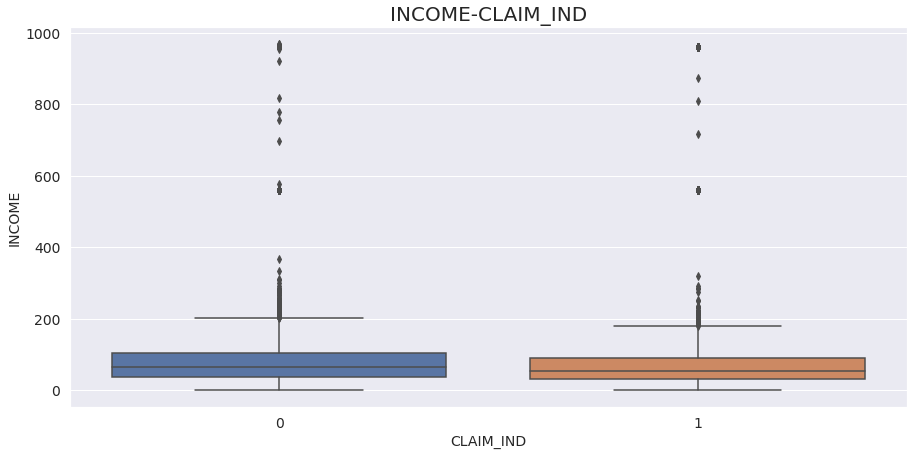

In [26]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='CLAIM_IND', y='INCOME', data=dataset)

plt.title('INCOME-CLAIM_IND', fontsize=20)
plt.ylabel('INCOME', fontsize=14)
plt.xlabel('CLAIM_IND', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Гипотеза 3. Обращение по страховке зависит от уровня образования. У людей с невысшим образование больше шансов обратиться по страховки.

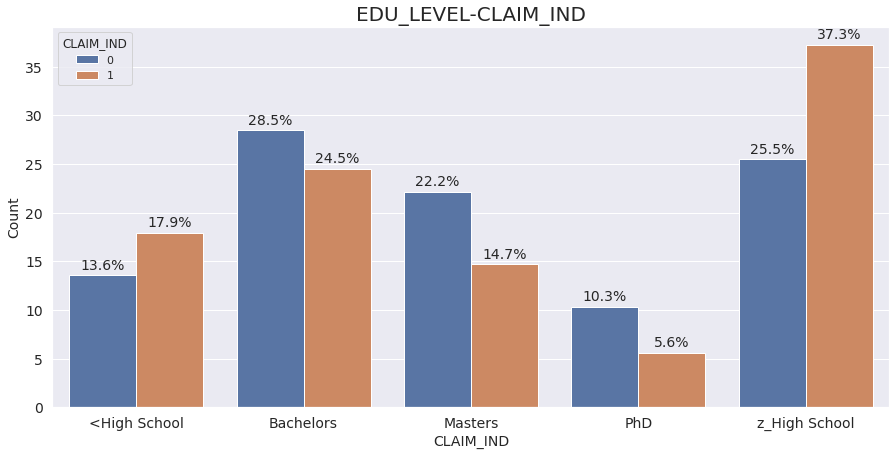

In [23]:
plt.figure(figsize=(15, 7))

educ_def = (dataset.groupby(['CLAIM_IND'])['EDU_LEVEL']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('EDU_LEVEL'))

ax = sns.barplot(x="EDU_LEVEL", y="percentage", hue="CLAIM_IND", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('EDU_LEVEL-CLAIM_IND', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('CLAIM_IND', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Гипотеза 4: Стоимость машины у людей, которые обращаются за страховой выплатой, меньше.

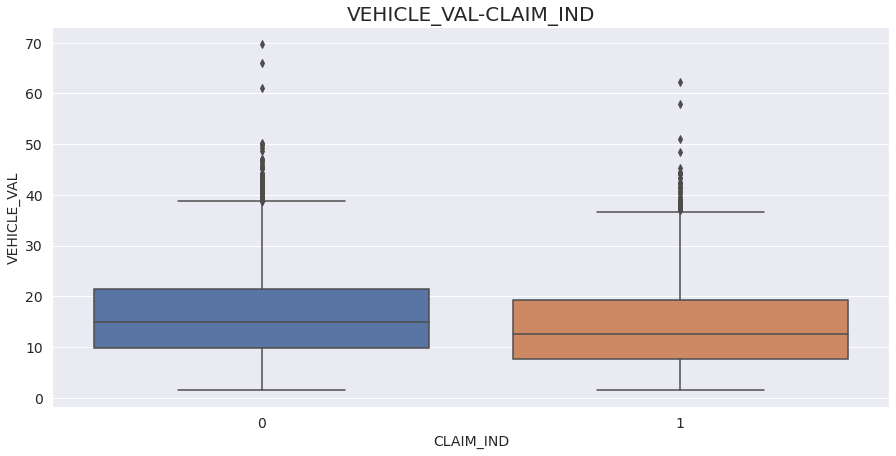

In [28]:
plt.figure(figsize=(15, 7))

sns.boxplot(x='CLAIM_IND', y='VEHICLE_VAL', data=dataset)

plt.title('VEHICLE_VAL-CLAIM_IND', fontsize=20)
plt.ylabel('VEHICLE_VAL', fontsize=14)
plt.xlabel('CLAIM_IND', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Гипотеза 5: У людей, которые используют машину для личных нужд, шанс обратиться по страховому случаю выше.

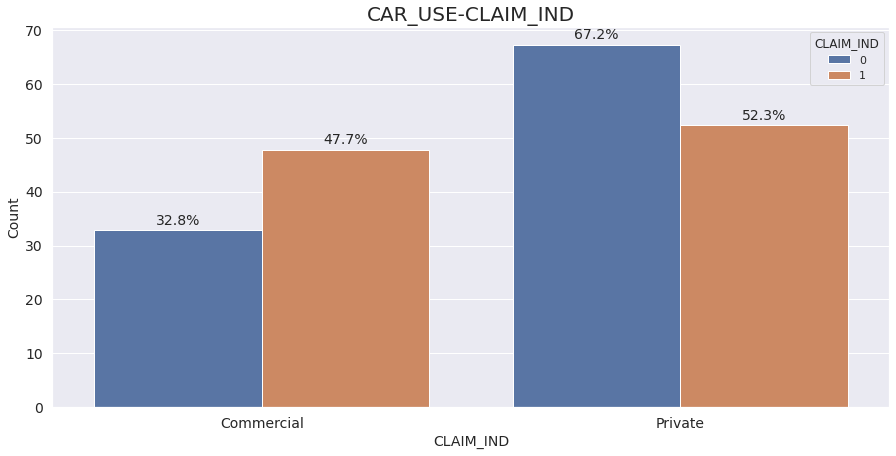

In [30]:
plt.figure(figsize=(15, 7))

educ_def = (dataset.groupby(['CLAIM_IND'])['CAR_USE']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('CAR_USE'))

ax = sns.barplot(x="CAR_USE", y="percentage", hue="CLAIM_IND", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('CAR_USE-CLAIM_IND', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('CLAIM_IND', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);